# 02. RAG Effectiveness Analysis

**Purpose:** Answer the core question: Does RAG help? When? By how much?

**Key Questions:**
- Does RAG improve performance over direct LLM?
- What % of RAG configurations actually help vs hurt?
- Under what conditions does RAG provide the most benefit?

In [1]:
from analysis_utils import (
    load_all_results, setup_plotting, effect_size,
    analyze_rag_benefit_distribution, compare_best_rag_vs_direct,
    identify_rag_success_factors, plot_rag_benefit_distribution,
    PRIMARY_METRIC, METRICS
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

setup_plotting()

# Load data
df = load_all_results()
rag_df = df[df['exp_type'] == 'rag']
direct_df = df[df['exp_type'] == 'direct']

print(f"Loaded {len(df)} experiments ({len(rag_df)} RAG, {len(direct_df)} Direct)")

Loaded 136 experiments (118 RAG, 18 Direct)


## 2.1 Overall RAG vs Direct Comparison

In [2]:
if len(direct_df) > 0 and len(rag_df) > 0 and PRIMARY_METRIC in df.columns:
    print("RAG vs Direct LLM Comparison")
    print("=" * 60)
    
    direct_mean = direct_df[PRIMARY_METRIC].mean()
    rag_mean = rag_df[PRIMARY_METRIC].mean()
    
    d, p, interp = effect_size(
        direct_df[PRIMARY_METRIC].dropna().values,
        rag_df[PRIMARY_METRIC].dropna().values
    )
    
    print(f"Direct LLM: {direct_mean:.4f} (n={len(direct_df)})")
    print(f"RAG (mean): {rag_mean:.4f} (n={len(rag_df)})")
    print(f"RAG (best): {rag_df[PRIMARY_METRIC].max():.4f}")
    print(f"\nMean difference: {rag_mean - direct_mean:+.4f} ({(rag_mean/direct_mean - 1)*100:+.1f}%)")
    print(f"Effect size (Cohen's d): {d:.3f} ({interp})")
    print(f"P-value: {p:.4f} {'✓ significant' if p < 0.05 else '✗ not significant'}")
    
    print("\n⚠️ NOTE: Mean RAG is confounded by many suboptimal configurations.")
    print("   See sections below for fair comparisons.")

RAG vs Direct LLM Comparison
Direct LLM: 0.1446 (n=18)
RAG (mean): 0.1069 (n=118)
RAG (best): 0.5492

Mean difference: -0.0378 (-26.1%)
Effect size (Cohen's d): -0.267 (small)
P-value: 0.2945 ✗ not significant

⚠️ NOTE: Mean RAG is confounded by many suboptimal configurations.
   See sections below for fair comparisons.


## 2.2 RAG Benefit Distribution

What % of RAG configurations actually help vs hurt?

RAG Benefit Distribution
Total RAG configurations: 118

RAG helps (>1% improvement): 14 (11.9%)
RAG hurts (>1% degradation): 69 (58.5%)
RAG neutral: 35 (29.7%)

When RAG helps, average benefit: +0.071
When RAG hurts, average penalty: -0.078

Best RAG config advantage: +0.169
Worst RAG config penalty: -0.496


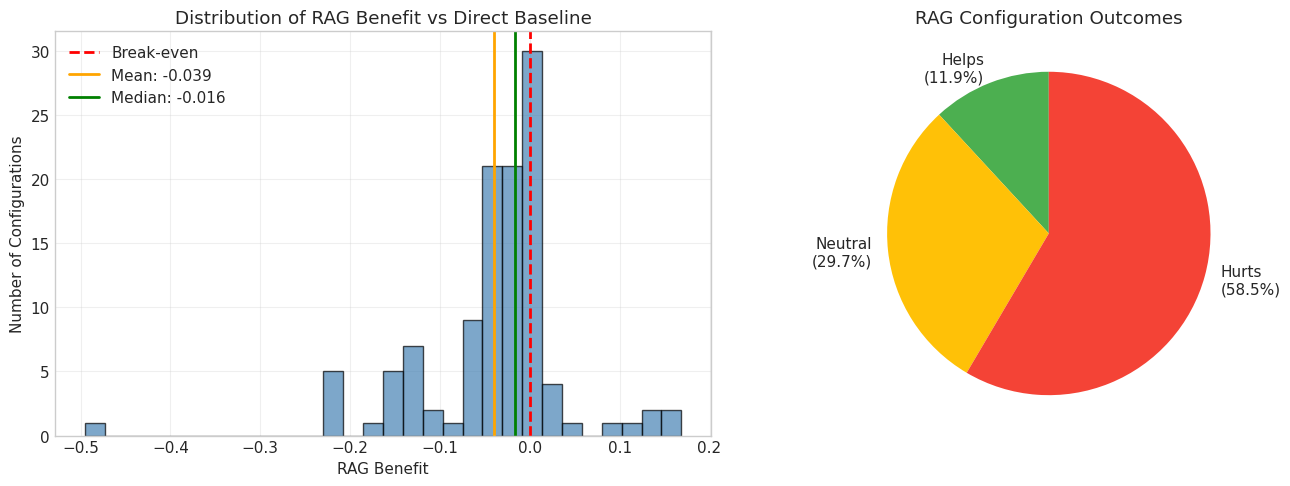

In [3]:
if len(df) > 0:
    benefit = analyze_rag_benefit_distribution(df)
    
    if benefit:
        print("RAG Benefit Distribution")
        print("=" * 60)
        print(f"Total RAG configurations: {benefit['n_helps'] + benefit['n_hurts'] + benefit['n_neutral']}")
        print(f"\nRAG helps (>1% improvement): {benefit['n_helps']} ({benefit['pct_helps']:.1f}%)")
        print(f"RAG hurts (>1% degradation): {benefit['n_hurts']} ({benefit['pct_hurts']:.1f}%)")
        print(f"RAG neutral: {benefit['n_neutral']} ({100 - benefit['pct_helps'] - benefit['pct_hurts']:.1f}%)")
        print(f"\nWhen RAG helps, average benefit: +{benefit['mean_benefit_when_helps']:.3f}")
        print(f"When RAG hurts, average penalty: {benefit['mean_hurt_when_hurts']:.3f}")
        print(f"\nBest RAG config advantage: +{benefit['best_rag_benefit']:.3f}")
        print(f"Worst RAG config penalty: {benefit['worst_rag_benefit']:.3f}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Distribution histogram
        plot_rag_benefit_distribution(benefit, ax=axes[0])
        
        # Pie chart
        sizes = [benefit['n_helps'], benefit['n_neutral'], benefit['n_hurts']]
        labels = [f"Helps\n({benefit['pct_helps']:.1f}%)", 
                  f"Neutral\n({100-benefit['pct_helps']-benefit['pct_hurts']:.1f}%)",
                  f"Hurts\n({benefit['pct_hurts']:.1f}%)"]
        colors = ['#4CAF50', '#FFC107', '#F44336']
        axes[1].pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
        axes[1].set_title('RAG Configuration Outcomes')
        
        plt.tight_layout()
        plt.show()

## 2.3 Fair Comparison: Best RAG vs Direct

Compare only the top RAG configurations against direct baseline.

In [4]:
if len(df) > 0:
    print("Best RAG vs Direct (Fair Comparison)")
    print("=" * 60)
    print("Comparing TOP-5 RAG configs against direct baseline per group:\n")
    
    comparison = compare_best_rag_vs_direct(df, top_k=5)
    
    if len(comparison) > 0:
        display_cols = ['group', 'direct_mean', 'top_rag_mean', 'best_rag', 'rag_advantage', 'rag_advantage_pct']
        display_cols = [c for c in display_cols if c in comparison.columns]
        display(comparison[display_cols].round(3))
        
        overall_advantage = comparison['rag_advantage'].mean()
        overall_advantage_pct = comparison['rag_advantage_pct'].mean()
        
        print(f"\n→ Average advantage of best RAG configs: +{overall_advantage:.3f} ({overall_advantage_pct:+.1f}%)")
        
        if overall_advantage > 0:
            print("✓ Best RAG configurations DO outperform direct LLM")
        else:
            print("✗ Even best RAG configurations underperform direct LLM")

Best RAG vs Direct (Fair Comparison)
Comparing TOP-5 RAG configs against direct baseline per group:



,group,direct_mean,top_rag_mean,best_rag,rag_advantage,rag_advantage_pct
0,Llama-3.2-3B / hotpotqa,0.167,0.152,0.180,-0.016,-9.362
1,Llama-3.2-3B / nq,0.246,0.255,0.261,0.009,3.716
2,Llama-3.2-3B / triviaqa,0.529,0.506,0.549,-0.023,-4.351
3,Phi-3-mini / hotpotqa,0.011,0.009,0.014,-0.002,-18.765
4,Phi-3-mini / nq,0.018,0.014,0.022,-0.004,-19.680
5,Phi-3-mini / triviaqa,0.024,0.019,0.026,-0.005,-21.646
6,Qwen-2.5-3B / hotpotqa,0.063,0.071,0.110,0.008,13.287
7,Qwen-2.5-3B / nq,0.061,0.100,0.202,0.039,63.974
8,Qwen-2.5-3B / triviaqa,0.183,0.299,0.352,0.116,63.178



→ Average advantage of best RAG configs: +0.014 (+7.8%)
✓ Best RAG configurations DO outperform direct LLM


## 2.4 What Makes RAG Succeed?

For each component, what % of configurations that use it actually help?

In [5]:
if len(df) > 0:
    success_factors = identify_rag_success_factors(df)
    
    if success_factors:
        print("What Makes RAG Succeed?")
        print("=" * 60)
        print("Percentage of configs that help, by component value:\n")
        
        for factor in ['retriever_type', 'reranker', 'prompt', 'query_transform']:
            if factor in success_factors:
                print(f"\n{factor}:")
                factor_df = success_factors[factor]
                for idx, row in factor_df.iterrows():
                    bar = '█' * int(row['pct_helps'] * 20)
                    print(f"  {str(idx):20s} | {bar:20s} {row['pct_helps']*100:5.1f}% help | avg: {row['mean_benefit']:+.3f}")

What Makes RAG Succeed?
Percentage of configs that help, by component value:


retriever_type:
  hierarchical         | █████                 29.4% help | avg: -0.003
  hybrid               | █                      9.5% help | avg: -0.046
  dense                | █                      8.5% help | avg: -0.043

reranker:
  bge-v2               | ████                  21.2% help | avg: -0.016
  none                 | █                      8.2% help | avg: -0.049

prompt:
  fewshot_3            | ██████████            50.0% help | avg: +0.036
  structured           | █                      5.0% help | avg: -0.018
  concise              |                        1.9% help | avg: -0.047
  cot                  |                        0.0% help | avg: -0.128

query_transform:
  multiquery           | ███                   17.2% help | avg: -0.022
  hyde                 | ██                    12.2% help | avg: -0.042
  none                 | █                      8.3% help | avg: -0.047


## 2.5 RAG Benefit by Model Strength

In [6]:
if len(df) > 0 and 'model_short' in df.columns:
    print("RAG Benefit by Model")
    print("=" * 60)
    
    results = []
    for model in df['model_short'].unique():
        model_rag = rag_df[rag_df['model_short'] == model]
        model_direct = direct_df[direct_df['model_short'] == model]
        
        if len(model_rag) == 0 or len(model_direct) == 0:
            continue
        
        direct_mean = model_direct[PRIMARY_METRIC].mean()
        best_rag = model_rag[PRIMARY_METRIC].max()
        n_beats = (model_rag[PRIMARY_METRIC] > direct_mean).sum()
        
        results.append({
            'model': model,
            'direct_baseline': direct_mean,
            'best_rag': best_rag,
            'best_rag_advantage': best_rag - direct_mean,
            'pct_configs_beat_direct': n_beats / len(model_rag) * 100
        })
    
    if results:
        results_df = pd.DataFrame(results).sort_values('direct_baseline')
        display(results_df.round(3))
        
        # Check correlation
        if len(results_df) > 2:
            corr = results_df['direct_baseline'].corr(results_df['best_rag_advantage'])
            if corr < -0.3:
                print(f"\n→ Negative correlation ({corr:.2f}): RAG helps WEAKER models more!")
            elif corr > 0.3:
                print(f"\n→ Positive correlation ({corr:.2f}): RAG helps STRONGER models more")
            else:
                print(f"\n→ Weak correlation ({corr:.2f}): RAG benefit is similar across models")

RAG Benefit by Model


,model,direct_baseline,best_rag,best_rag_advantage,pct_configs_beat_direct
1,Phi-3-mini,0.018,0.026,0.008,8.333
2,Qwen-2.5-3B,0.102,0.352,0.249,23.810
0,Llama-3.2-3B,0.314,0.549,0.235,22.500



→ Positive correlation (0.68): RAG helps STRONGER models more


## 2.6 RAG Benefit by Dataset

In [7]:
if len(df) > 0 and 'dataset' in df.columns:
    print("RAG Benefit by Dataset")
    print("=" * 60)
    
    results = []
    for dataset in df['dataset'].unique():
        ds_rag = rag_df[rag_df['dataset'] == dataset]
        ds_direct = direct_df[direct_df['dataset'] == dataset]
        
        if len(ds_rag) == 0 or len(ds_direct) == 0:
            continue
        
        direct_mean = ds_direct[PRIMARY_METRIC].mean()
        best_rag = ds_rag[PRIMARY_METRIC].max()
        n_beats = (ds_rag[PRIMARY_METRIC] > direct_mean).sum()
        
        results.append({
            'dataset': dataset,
            'direct_baseline': direct_mean,
            'best_rag': best_rag,
            'best_rag_advantage': best_rag - direct_mean,
            'pct_configs_beat_direct': n_beats / len(ds_rag) * 100
        })
    
    if results:
        results_df = pd.DataFrame(results).sort_values('direct_baseline')
        display(results_df.round(3))
        
        best_dataset = results_df.loc[results_df['best_rag_advantage'].idxmax(), 'dataset']
        print(f"\n→ RAG helps most on: {best_dataset}")

RAG Benefit by Dataset


,dataset,direct_baseline,best_rag,best_rag_advantage,pct_configs_beat_direct
0,hotpotqa,0.080,0.180,0.100,34.884
1,nq,0.108,0.261,0.153,29.268
2,triviaqa,0.245,0.549,0.304,38.235



→ RAG helps most on: triviaqa


## 2.7 Key Takeaways

In [8]:
if len(df) > 0:
    benefit = analyze_rag_benefit_distribution(df)
    
    print("KEY TAKEAWAYS")
    print("=" * 60)
    
    if benefit:
        if benefit['pct_helps'] > 50:
            print("→ Most RAG configs help. Focus on avoiding the bad configurations.")
        elif benefit['pct_helps'] > 30:
            print("→ RAG is risky - only ~1/3 of configs help. Configuration matters A LOT.")
        else:
            print("→ Most RAG configs hurt performance. Only use RAG with proven configs.")
        
        if benefit['best_rag_benefit'] > 0.05:
            print(f"→ Best RAG config gives +{benefit['best_rag_benefit']:.1%} over direct - substantial potential.")
        
        # Winning formula
        success_factors = identify_rag_success_factors(df)
        if success_factors:
            print("\nWINNING FORMULA (components most likely to help):")
            for factor, factor_df in success_factors.items():
                if len(factor_df) > 0:
                    best_value = factor_df['pct_helps'].idxmax()
                    best_pct = factor_df.loc[best_value, 'pct_helps'] * 100
                    if best_pct > 40:
                        print(f"  - {factor}: {best_value} ({best_pct:.0f}% of configs help)")

KEY TAKEAWAYS
→ Most RAG configs hurt performance. Only use RAG with proven configs.
→ Best RAG config gives +16.9% over direct - substantial potential.

WINNING FORMULA (components most likely to help):
  - prompt: fewshot_3 (50% of configs help)
